## Mount your google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Model importing

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers, datasets, Sequential
from tensorflow.keras.layers import Conv2D,Activation,MaxPooling2D,Dropout,Flatten,Dense
import  os
import numpy as np
import matplotlib.pyplot as plt


##Data Reading (already preprocessed)

In [2]:
#download Cifar-10 dataset
(x_train,y_train), (x_test, y_test) = datasets.cifar10.load_data()
#print the size of the dataset
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
print(y_train[0])

#Convert the category label into onehot encoding 
num_classes = 10
y_train_onehot = keras.utils.to_categorical(y_train, num_classes)
y_test_onehot = keras.utils.to_categorical(y_test, num_classes)
print(y_train_onehot[0])
y_train[0]


170508288/170498071 [==============================] - 2s 0us/step
(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)
[6]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


array([6], dtype=uint8)

Snapshot of the dataset images


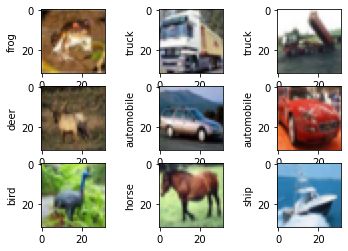

In [3]:
#Create a image tag list
category_dict = {0:'airplane',1:'automobile',2:'bird',3:'cat',4:'deer',5:'dog',
                 6:'frog',7:'horse',8:'ship',9:'truck'}
#Show the first 9 images and their labels
plt.figure()
for i in range(9):
    #create a figure with 9 subplots
    plt.subplot(3,3,i+1)
    #show an image
    plt.imshow(x_train[i])
    #show the label
    plt.ylabel(category_dict[y_train[i][0]])
plt.show()


### Data Normalization

In [4]:
#Pixel normalization
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255
# first picture in the training set
print(x_train[0])

[[[0.23137255 0.24313726 0.24705882]
  [0.16862746 0.18039216 0.1764706 ]
  [0.19607843 0.1882353  0.16862746]
  ...
  [0.61960787 0.5176471  0.42352942]
  [0.59607846 0.49019608 0.4       ]
  [0.5803922  0.4862745  0.40392157]]

 [[0.0627451  0.07843138 0.07843138]
  [0.         0.         0.        ]
  [0.07058824 0.03137255 0.        ]
  ...
  [0.48235294 0.34509805 0.21568628]
  [0.46666667 0.3254902  0.19607843]
  [0.47843137 0.34117648 0.22352941]]

 [[0.09803922 0.09411765 0.08235294]
  [0.0627451  0.02745098 0.        ]
  [0.19215687 0.10588235 0.03137255]
  ...
  [0.4627451  0.32941177 0.19607843]
  [0.47058824 0.32941177 0.19607843]
  [0.42745098 0.28627452 0.16470589]]

 ...

 [[0.8156863  0.6666667  0.3764706 ]
  [0.7882353  0.6        0.13333334]
  [0.7764706  0.6313726  0.10196079]
  ...
  [0.627451   0.52156866 0.27450982]
  [0.21960784 0.12156863 0.02745098]
  [0.20784314 0.13333334 0.07843138]]

 [[0.7058824  0.54509807 0.3764706 ]
  [0.6784314  0.48235294 0.16470589]


## CNN Construction

In [5]:
def CNN_classification_model(input_size = x_train.shape[1:]):
    model = Sequential() 
    #the first block with 2 convolutional layers and 1 maxpooling layer
    '''Conv1 with 32 3*3 kernels 
        padding="same": it applies zero padding to the input image so that the input image gets fully covered by the filter and specified stride.
        It is called SAME because, for stride 1 , the output will be the same as the input.
        output: 32*32*32'''
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_size)) 
    #relu activation function
    model.add(Activation('relu')) 
    #Conv2
    model.add(Conv2D(32, (3, 3))) 
    model.add(Activation('relu')) 
    #maxpooling 
    model.add(MaxPooling2D(pool_size=(2, 2),strides =1)) 

    #the second block
    model.add(Conv2D(64, (3, 3), padding='same')) 
    model.add(Activation('relu')) 
    model.add(Conv2D(64, (3, 3))) 
    model.add(Activation('relu')) 
    #maxpooling.the default strides =1
    model.add(MaxPooling2D(pool_size=(2, 2))) 
  

    #Before sending a feature map into a fully connected network, it should be flattened into a column vector. 
    model.add(Flatten()) 
    #fully connected layer
    model.add(Dense(128)) 
    model.add(Activation('relu')) 
    #dropout layer every neuronis set to 0 with a probability of 0.25
    model.add(Dropout(0.25))
    model.add(Dense(num_classes))
    #map the score of each class into probability
    model.add(Activation('softmax')) 
    
    opt = keras.optimizers.Adam(learning_rate=0.0001)
    
    model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy']) 
    return model



In [6]:
model=CNN_classification_model()


In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 30, 30, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 29, 29, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 29, 29, 64)        18496     
                                                        

## Training the model 
Choose which models to saves, here we choose to save only the best so far

In [8]:
from tensorflow.keras.callbacks import ModelCheckpoint

path = "/content/drive/MyDrive/Colab Notebooks/2022/"
model_name = path + "final_cifar10.h5"
model_checkpoint = ModelCheckpoint(model_name, monitor='loss', verbose=1, save_best_only=True)


e = 3 #10
b = 128 #32
#train
model.fit(x_train,y_train, batch_size = b, epochs = e,callbacks = [model_checkpoint],verbose=1)

Epoch 1/3
391/391 [==============================] - ETA: 0s - loss: 1.7661 - accuracy: 0.3608
Epoch 1: loss improved from inf to 1.76612, saving model to /content/drive/MyDrive/Colab Notebooks/2022/final_cifar10.h5
391/391 [==============================] - 25s 40ms/step - loss: 1.7661 - accuracy: 0.3608
Epoch 2/3
391/391 [==============================] - ETA: 0s - loss: 1.4329 - accuracy: 0.4860
Epoch 2: loss improved from 1.76612 to 1.43290, saving model to /content/drive/MyDrive/Colab Notebooks/2022/final_cifar10.h5
391/391 [==============================] - 14s 35ms/step - loss: 1.4329 - accuracy: 0.4860
Epoch 3/3
391/391 [==============================] - ETA: 0s - loss: 1.3145 - accuracy: 0.5329
Epoch 3: loss improved from 1.43290 to 1.31452, saving model to /content/drive/MyDrive/Colab Notebooks/2022/final_cifar10.h5
391/391 [==============================] - 14s 35ms/step - loss: 1.3145 - accuracy: 0.5329


## Testing the model

In [9]:
new_model = CNN_classification_model()
new_model.load_weights(path + 'final_cifar10.h5')

model.evaluate(x_test, y_test, verbose=1)


313/313 [==============================] - 3s 8ms/step - loss: 1.2204 - accuracy: 0.5674


[1.2203800678253174, 0.5673999786376953]

Predict on a single image.

In [10]:
#output the possibility of each class
new_model.predict(x_test[0:1])


array([[0.01906835, 0.00901849, 0.0862297 , 0.5253493 , 0.02819557,
        0.12737074, 0.16151509, 0.00292499, 0.03649128, 0.00383641]],
      dtype=float32)

In [11]:
np.argmax(new_model.predict(x_test[0:1]), axis=1)

array([3])

Plot the first 4 images in the test set and their corresponding predicted labels.

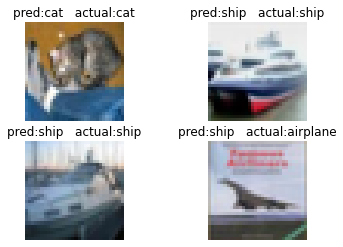

In [13]:
#label list
pred_list = []
#predict
pred = np.argmax(new_model.predict(x_test[0:4]), axis=1)
plt.figure()
for i in range(0,4):
    plt.subplot(2,2,i+1)
    #plot
    plt.imshow(x_test[i])
    
    #Display actual and predicted labels of images
    plt.title("pred:"+category_dict[pred[i]]+"   actual:"+ category_dict[y_test[i][0]])
    plt.axis('off')
plt.show()
